In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from numpy.linalg import inv, cholesky
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
%load_ext autoreload
%autoreload 2

# Bivariate Normal with unit variance

To start with a simple example we can assume two continuous effects $y = (y_1, y_2)$ that are distributed normally $y_i \sim N(\mu_i, 1)$ with unit variance and are given equal weights $w_1 = w_2 = 1$. For simplicity, let's assume that the score is simply the sum of the means $s = \mu_1 + \mu_2$. 

This scoring rule makes no use of any possible correlation between $y_1$ and $y_2$. Let's assume that $\text{corr}(y_1, y_2) = \rho$. 

Let's say $\mu_1 = 2, \mu_2 = 3$ and $\rho = 0.5$

We see that $s =\mu_1+ \mu_2 = 2+ 3 = 5$ 

true mean:  [2 3]
emp mean:  [1.998 2.997]
true var:  [1. 1.]
emp var:  [0.999 1.   ]
true Cov:
 [[1.  0.5]
 [0.5 1. ]]
emp Cov:
 [[0.999 0.499]
 [0.499 1.   ]]
score = 4.99


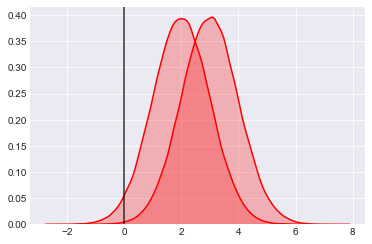

In [2]:
# generate x ~ N(mu, Cov) 
N = 100000
mean = np.array([2,3])
R = np.array([[1,.5],[.5,1]])
sigma = np.array([1,1])**(.5)
C = np.diag(sigma) @ R @ np.diag(sigma)
x = multivariate_normal.rvs(mean=mean, cov=C, size=N)
print("true mean: ",np.round(mean, 3)) 
print("emp mean: ", np.round(np.mean(x, axis=0), 3))
print("true var: ",np.round(sigma**2, 3)) 
print("emp var: ", np.round(np.var(x, axis=0), 3))
print("true Cov:\n", np.round(C, 3))
print("emp Cov:\n", np.round(np.cov(x.T), 3))

s = np.sum(np.mean(x, axis=0))
print("score = %.2f"%(s))

sns.kdeplot(x[:,0], shade=True, color='r');
sns.kdeplot(x[:,1], shade=True, color='r');
plt.axvline(0, alpha=.6, color='black', linestyle='-', lw=2);


# Analytical derivation

We have that $x \sim N(\mu, \Sigma)$ with 

$$
\Sigma = 
\begin{bmatrix}
   1    & \rho  \\
   \rho & 1
\end{bmatrix}
$$

which means that the Cholesky$(\Sigma) = L$

$$
L = 
\begin{bmatrix}
   1    & 0  \\
   \rho & (1-\rho^2)^{1/2}
\end{bmatrix}
$$


If we take the transform 
$$
x_s = \Sigma^{-1/2} x
$$

The resulting variables are distributed as 
$$
x_s \sim N (\Sigma^{-1/2} \mu, I)
$$

where 

$$
\Sigma^{-1/2} = L ^{-1} =
\begin{bmatrix}
  1    & 0  \\
  -\rho(1-\rho^2)^{-1/2} & (1-\rho^2)^{-1/2}
\end{bmatrix}
$$


In that case we expect the score to be equal $s = \bar\mu_1 + \bar\mu_2$ where
$$
\bar\mu = L^{-1}\mu = ( \mu_1 ,\frac{\mu_2 - \rho \mu_1}{(1-\rho^2)^{1/2}} )
$$

We can view $\bar\mu (\rho)$ as a function of $\rho$ and confirm that $\bar\mu(0) =( \mu_1 , \mu_2 )$. 

As a simple example we can also consider the case for $\mu_1 = \mu_2 = \mu$ and see that 

$$
s(\rho) = \bar \mu_1 + \bar \mu_2 = \mu + \mu \frac{1-\rho}{(1-\rho^2)^{1/2}} = \mu + \mu \big( \frac{1-\rho}{1+\rho} \big) ^{1/2}  
$$


Below we plot the function $s(\rho)$ for $\rho \in [0,1]$ and different $\mu_1,\mu_2$ values.

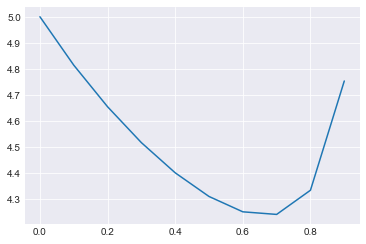

In [3]:
def analytical_score(rho, mean):
    mu1 = mean[0]
    mu2 = (mean[1] - rho*mean[0])*(1-rho**2)**(-.5)
    score = mu1 + mu2
    return np.round(score,3)

mean = np.array([2,3])
scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = analytical_score(x[i], mean)

plt.plot(x, scores);

# Confirm with simulation

Generate $x \sim N(\mu, \Sigma)$ and then compute 
$\Sigma^{-1/2}$ as follows: 

1. calculate the empirical covariance of $Cov(x) = S$
2. calculate its cholesky factor of $L = Cholesky(S)$ such that $S = L L^T$
3. take the inverse $L^{-1}$. 

Then take the transformation 
$$
x_s = \Sigma^{-1/2} x
$$
and confirm that the sample mean of $x_s$ is $\Sigma^{-1/2} \mu$. 

We can also calculate the score to be equal to $s = \bar\mu_1 + \bar\mu_2$ where
$$
\bar\mu = \Sigma^{-1/2} (\mu_1 , \mu_2)
$$
We first try it for $\rho =0$ to test that we still get $s = 5$


true mean:  [2 3]
emp mean:  [2.002 3.002]
true var:  [1. 1.]
emp var:  [0.996 0.999]
true Cov:
 [[1. 0.]
 [0. 1.]]
emp Cov:
 [[ 0.996 -0.003]
 [-0.003  0.999]]
mean std:  [2.006 3.01 ]
var std:  [1. 1.]
emp Cov:
 [[1. 0.]
 [0. 1.]]
Sigma^(-1/2) * mean:  [2.004 3.009]
score = 5.02


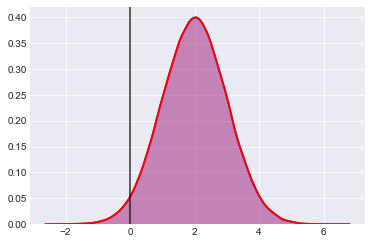

In [4]:
# generate x ~ N(mu, Cov) 
# Check that mean of scaled x, NOT standardixed, is Sigma^(-1/2) mu
# generate x ~ N(mu, Cov) 
N = 100000
rho = 0
mean = np.array([2,3])
R = np.array([[1,rho],[rho,1]])
sigma = np.array([1,1])**(.5)
C = np.diag(sigma) @ R @ np.diag(sigma)
x = multivariate_normal.rvs(mean=mean, cov=C, size=N)
print("true mean: ",np.round(mean, 3)) 
print("emp mean: ", np.round(np.mean(x, axis=0), 3))
print("true var: ",np.round(sigma**2, 3)) 
print("emp var: ", np.round(np.var(x, axis=0), 3))
print("true Cov:\n", np.round(C, 3))
print("emp Cov:\n", np.round(np.cov(x.T), 3))



S = np.cov(x.T)
S_inv = inv(cholesky(S))
x_s = (S_inv @ x.T).T
print("mean std: ", np.round(np.mean(x_s, axis=0), 3))
print("var std: ", np.round(np.var(x_s, axis=0), 3))
print("emp Cov:\n", np.round(np.cov(x_s.T), 3))
print("Sigma^(-1/2) * mean: ",np.round(S_inv @ mean, 3)) 
s = np.sum(np.mean(x_s, axis=0))
print("score = %.2f"%(s))


sns.kdeplot(x[:,0], shade=True , color = 'b');
sns.kdeplot(x_s[:,0], shade=True, color='r',  lw = 2, linestyle = '-');
plt.axvline(0, alpha=.6, color='black', linestyle='-', lw=2);

And then test it with $\rho =0.5$ to see that the score drops to $s = 4.33$

true mean:  [2 3]
emp mean:  [1.998 3.   ]
true var:  [1. 1.]
emp var:  [0.997 1.006]
true Cov:
 [[1.  0.5]
 [0.5 1. ]]
emp Cov:
 [[0.997 0.501]
 [0.501 1.006]]
mean std:  [2.002 2.297]
var std:  [1. 1.]
emp Cov:
 [[1. 0.]
 [0. 1.]]
Sigma^(-1/2) * mean:  [2.003 2.296]
score = 4.30


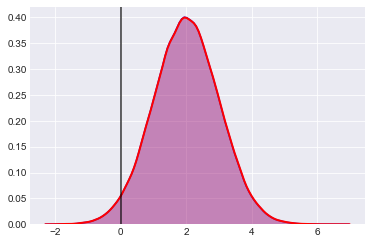

In [5]:
# generate x ~ N(mu, Cov) 
# Check that mean of scaled x, NOT standardixed, is Sigma^(-1/2) mu
# generate x ~ N(mu, Cov) 
N = 100000
rho = 0.5
mean = np.array([2,3])
R = np.array([[1,rho],[rho,1]])
sigma = np.array([1,1])**(.5)
C = np.diag(sigma) @ R @ np.diag(sigma)
x = multivariate_normal.rvs(mean=mean, cov=C, size=N)
print("true mean: ",np.round(mean, 3)) 
print("emp mean: ", np.round(np.mean(x, axis=0), 3))
print("true var: ",np.round(sigma**2, 3)) 
print("emp var: ", np.round(np.var(x, axis=0), 3))
print("true Cov:\n", np.round(C, 3))
print("emp Cov:\n", np.round(np.cov(x.T), 3))



S = np.cov(x.T)
S_inv = inv(cholesky(S))
x_s = (S_inv @ x.T).T
print("mean std: ", np.round(np.mean(x_s, axis=0), 3))
print("var std: ", np.round(np.var(x_s, axis=0), 3))
print("emp Cov:\n", np.round(np.cov(x_s.T), 3))
print("Sigma^(-1/2) * mean: ",np.round(S_inv @ mean, 3)) 
s = np.sum(np.mean(x_s, axis=0))
print("score = %.2f"%(s))


sns.kdeplot(x[:,0], shade=True , color = 'b');
sns.kdeplot(x_s[:,0], shade=True, color='r',  lw = 2, linestyle = '-');
plt.axvline(0, alpha=.6, color='black', linestyle='-', lw=2);

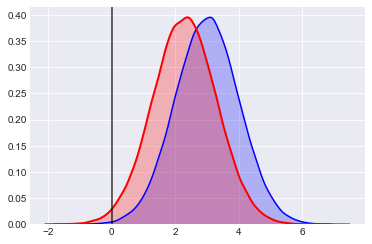

In [6]:
sns.kdeplot(x[:,1], shade=True , color = 'b');
sns.kdeplot(x_s[:,1], shade=True, color='r',  lw = 2, linestyle = '-');
plt.axvline(0, alpha=.6, color='black', linestyle='-', lw=2);


We write a function to calculate the score for all $\rho \in [0,1]$ empirically and confirm that it agrees with the analytical solution.

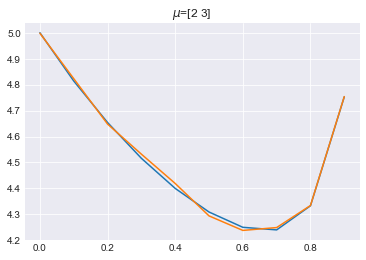

In [7]:
def empirical_score(rho, mean):
    N = 100000
    R = np.array([[1,rho],[rho,1]])
    sigma = np.array([1,1])**(.5)
    C = np.diag(sigma) @ R @ np.diag(sigma)
    x = multivariate_normal.rvs(mean=mean, cov=C, size=N)

    S = np.cov(x.T)
    S_inv = inv(cholesky(S))
    x_s = (S_inv @ x.T).T
    score = np.sum(np.mean(x_s, axis=0))
    return np.round(score,3)

mean = np.array([2,3])


scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = analytical_score(x[i], mean)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean));


scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = empirical_score(x[i], mean)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean));

# General bivariate case

We have that $x \sim N(\mu, \Sigma)$ with 

$$
\Sigma = 
\begin{bmatrix}
   \sigma_1^2    &    \sigma_1\sigma_2\rho  \\
\sigma_1\sigma_2\rho &    \sigma_2^2
\end{bmatrix}
$$

which means that the Cholesky$(\Sigma) = L$

$$
L = 
\begin{bmatrix}
   \sigma_1   & 0  \\
   \rho   \sigma_2 &    \sigma_2(1-\rho^2)^{1/2}
\end{bmatrix}
$$


If we take the transform 
$$
x_s = \Sigma^{-1/2} x
$$

The resulting variables are distributed as 
$$
x_s \sim N (\Sigma^{-1/2} \mu, I)
$$

where 

$$
\Sigma^{-1/2} = L ^{-1} =
\begin{bmatrix}
     \sigma_1^{-1}    & 0  \\
  \frac{-\rho} {\sigma_1(1-\rho^2)^{1/2}} &  \frac{1} {\sigma_2(1-\rho^2)^{1/2}}
\end{bmatrix}
$$


In that case we expect the score to be equal $s = \bar\mu_1 + \bar\mu_2$ where
$$
\bar\mu = L^{-1}\mu = ( \sigma_1^-1 \mu_1 ~ , ~\frac{1}{(1-\rho^2)^{1/2}} \cdot (\frac{\mu_2}{\sigma_2} - \rho\frac{\mu_1}{\sigma_1}))
$$

We can view $\bar\mu (\rho)$ as a function of $\rho$ and confirm that $\bar\mu(0) =(\frac{\mu_1}{\sigma_1} ,\frac{\mu_2}{\sigma_2} )$

In [8]:
def analytical_score_general(rho, mean, sigma ):
    mu1 = mean[0] / sigma[0]
    mu2 = (mean[1]/sigma[1] - rho*mean[0]/sigma[0])*(1-rho**2)**(-.5)
    score = mu1 + mu2
    return np.round(score,3)

def empirical_score_general(rho, mean, sigma):
    N = 100000
    R = np.array([[1,rho],[rho,1]])
    C = np.diag(sigma) @ R @ np.diag(sigma)
    x = multivariate_normal.rvs(mean=mean, cov=C, size=N)

    S = np.cov(x.T)
    S_inv = inv(cholesky(S))
    x_s = (S_inv @ x.T).T
    score = np.sum(np.mean(x_s, axis=0))
    return np.round(score,3)

Below we plot a few examples for different values of $\sigma,\mu$ both analytica and empirical score and confirm tha they agree. 

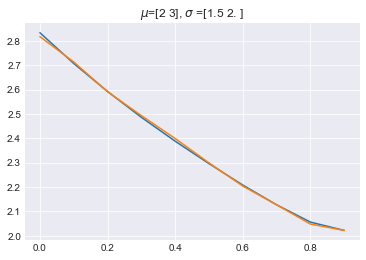

In [9]:

mean = np.array([2,3])
sigma = np.array([1.5,2])

scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = analytical_score_general(x[i], mean, sigma)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean) +', $\sigma$ ='+str(sigma));


scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = empirical_score_general(x[i], mean, sigma)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean) +', $\sigma$ ='+str(sigma));

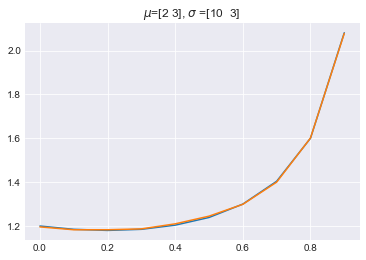

In [10]:
mean = np.array([2,3])
sigma = np.array([10,3])

scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = analytical_score_general(x[i], mean, sigma)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean) +', $\sigma$ ='+str(sigma));


scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = empirical_score_general(x[i], mean, sigma)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean) +', $\sigma$ ='+str(sigma));

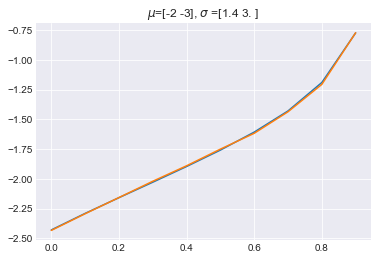

In [11]:
mean = np.array([-2,-3])
sigma = np.array([1.4,3])

scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = analytical_score_general(x[i], mean, sigma)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean) +', $\sigma$ ='+str(sigma));


scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = empirical_score_general(x[i], mean, sigma)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean) +', $\sigma$ ='+str(sigma));

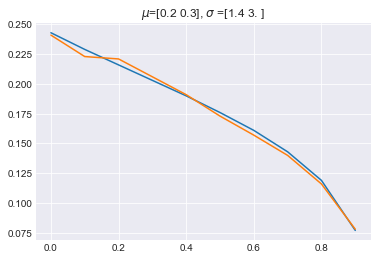

In [12]:
mean = np.array([.2,.3])
sigma = np.array([1.4,3])

scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = analytical_score_general(x[i], mean, sigma)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean) +', $\sigma$ ='+str(sigma));


scores = np.empty(10)
x = np.arange(0,1,.1)
for i in range(10):
    scores[i] = empirical_score_general(x[i], mean, sigma)

plt.plot(x, scores);
plt.title('$\mu$='+str(mean) +', $\sigma$ ='+str(sigma));